In [1]:
from keras.datasets import mnist
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas.plotting import scatter_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])
print(X_train)

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [5]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [6]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train)
print(y_train)

print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
(48000, 784)
(12000, 784)


In [8]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [24]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01, epochs = 10, batch_size = 20, verbose = True):
        self.params = {}
        self.epochs = epochs
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        self.verbose = verbose
        self.batch_size = batch_size
        
        pass
    
    
    #シグモイド関数
    def sigmoid(self, a):
        return 1/(1+np.exp(-a))
    
    #ハイポニックタンジェント
    def tanh(self, a):
        return (1-np.tanh(a)**2)
    
    #ソフトマックス関数
    def softmax(self, x):
        c = np.max(x)
        exp_a = np.exp(x - c)
        sum_exp_a = np.sum(exp_a)
        y = exp_a / sum_exp_a
        return y

    #交差エントロピー誤差
#     def cross_entropy_error(self, y, t) :
#         if y.ndim == 1:
#             t = t.reshape(1, t.size)
#             y = y.reshape(1, y.size)
#         print(y)
#         print (t)
#         print(y.dtype)
#         print (t.dtype)
#         print(y[np.arange(self.batch_size),t])
#         print(self.batch_size)
            
#         CEE = -np.sum(t*np.log(y[np.arange(self.batch_size), t])) / self.batch_size
                   
#         return
    #交差エントロピー誤差
    def cross_entropy_error(self,y,t):
        delta = 1e-7
        return -np.mean(t*np.log(y+delta))
        
#     # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
#         if t.size == y.size:
#             t = t.argmax(axis=1)
             
# #         batch_size = y.shape[0]
#         return -np.sum(np.log(y[np.arange(self.batch_size), t] + 1e-7)) / self.batch_size
    
    #ロスの計算
    def loss(self, x, t):
        y = self.predict(x)
        return self.cross_entropy_error(y,t)
    
    #タンジェントを使った割戻し
    def tahn_grad(self, x):
        return (1.0 - self.tanh(x)) * self.tanh(x)
    
        
    def fit(self, x, t, x_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        grads = {}
        self.batch_size=20
        self.loss_list=[]
        
        for epoch in range(self.epochs):
            GMB = GetMiniBatch(x, t, batch_size=self.batch_size, seed=0)
            for min_x, min_t in GMB:
                
                #forward
                a1 = np.dot(min_x, W1) + b1
                z1 = self.tanh(a1)
                a2 = np.dot(z1, W2) + b2
                y = self.softmax(a2)
#                 print('a2:{}'.format(a2))
#                 print('y:{}'.format(y))
#                 print('min_t:{}'.format(min_t))
#                 print('batch_size:{}'.format(self.batch_size))

                #backword
                dy = (y - min_t) / self.batch_size
                grads['W2'] = np.dot(z1.T, dy)
                grads['b2'] = np.sum(dy, axis=0)

                dz1 = np.dot(dy, W2.T)
                da1 = self.tahn_grad(a1) * dz1
                grads['W1'] = np.dot(min_x.T, da1)
                grads['b1'] = np.sum(da1, axis=0)
                W2-=grads['W2']
                b2-=grads['b2']
                W1-=grads['W1']
                b1-=grads['b1']
                
            self.loss_list.append(self.loss(x, t))
            print('回数:{}'.format(epoch))

        return grads

    def gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
        
        if self.verbose:#verboseをTrueにした際は学習過程などを出力する
            print()
        pass
    
    def predict(self, x):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        # テストデータによる精度チェック       
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = self.sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = self.softmax(a2)
        
        return y
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def plot(self):
        # 精度推移グラフ表示    
        plt.plot(self.loss_list, label='loss')
        plt.legend()
        plt.show()

In [25]:
NN = ScratchSimpleNeuralNetrowkClassifier(input_size=784, hidden_size=100, output_size=10, epochs=30)

In [26]:
NN.fit(X_train, y_train)

回数:0
回数:1
回数:2
回数:3
回数:4
回数:5
回数:6
回数:7
回数:8
回数:9
回数:10
回数:11
回数:12
回数:13
回数:14
回数:15
回数:16
回数:17
回数:18
回数:19
回数:20
回数:21
回数:22
回数:23
回数:24
回数:25
回数:26
回数:27
回数:28
回数:29


{'W2': array([[ 5.29785431e-10, -4.05348655e-07,  1.33016897e-10,
          7.26071254e-09,  1.30437754e-10, -1.50013517e-08,
          6.13237281e-10,  2.53532646e-09,  2.64411639e-10,
          2.05376319e-09],
        [ 5.21390297e-10, -3.81615437e-07,  1.14334629e-10,
          7.14565195e-09, -1.51226599e-11, -3.11079270e-08,
          6.03518796e-10,  1.72693776e-09,  2.15689488e-10,
          2.02034255e-09],
        [ 4.95430290e-10, -3.76268148e-07,  1.25693807e-10,
          6.78986956e-09,  1.65374282e-10, -1.67312874e-08,
          5.73470259e-10,  2.23988892e-09,  2.39261543e-10,
          1.92074307e-09],
        [ 5.91254382e-10, -4.35858204e-07,  1.37121909e-10,
          8.10312319e-09,  8.30458572e-11, -3.22876505e-08,
          6.84387788e-10,  1.93197003e-09,  2.82089274e-10,
          2.29191341e-09],
        [ 4.96013588e-10, -3.68347973e-07,  7.75933895e-11,
          6.79784620e-09, -1.93994707e-10, -2.40023229e-08,
          5.74145080e-10,  1.62057238e-09,  1.

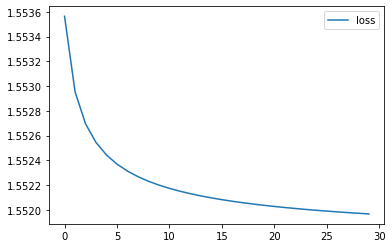

In [27]:
NN.plot()

In [28]:
pred = NN.predict(X_val)

In [29]:
NN.accuracy(X_val, y_val)

0.11191666666666666